#  LSTM and GRU for classification

### LSTM model 

Following the LSTM formulation and reference to build the model:

Input gate: $\mathbf{I}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xi}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hi}}+\mathbf{b}_{\mathrm{i}}\right)$ (1)

Forget gate: $\mathbf{F}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xf}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hf}}+\mathbf{b}_{\mathrm{f}}\right)$ (2)

Output gate: $\mathbf{O}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xo}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{ho}}+\mathbf{b}_o\right)$ (3)

Input node: $\tilde{\mathbf{C}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{\mathrm{xc}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hc}}+\mathbf{b}_{\mathrm{c}}\right)$ (4)

Memory cell internal state: $\mathbf{C}_t=\mathbf{F}_t \odot \mathbf{C}_{t-1}+\mathbf{I}_t \odot \tilde{\mathbf{C}}_t$ (5)

Hidden state: $\mathbf{H}_t=\mathbf{O}_t \odot \tanh \left(\mathbf{C}_t\right)$ (6)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, lr):
        super(LSTM, self).__init__()
        self.lr = lr
        self.hidden_dim = hidden_dim
        
        # Input gate parameters
        self.W_xi = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hi = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_i = nn.Parameter(torch.zeros(hidden_dim))
        
        # Forget gate parameters
        self.W_xf = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hf = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_f = nn.Parameter(torch.zeros(hidden_dim))
        
        # Output gate parameters
        self.W_xo = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_ho = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_o = nn.Parameter(torch.zeros(hidden_dim))
        
        # Input node parameters
        self.W_xc = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hc = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_c = nn.Parameter(torch.zeros(hidden_dim))
        
        # Final classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, inputs, H_C=None):
        batch_size = inputs.size(0)
        seq_length = inputs.size(1)  
        
        outputs = []
        if H_C is None:
            H = torch.zeros(batch_size, self.hidden_dim).to(inputs.device)
            C = torch.zeros(batch_size, self.hidden_dim).to(inputs.device)
        else:
            H, C = H_C
            
        # Process each timestep
        for t in range(seq_length):
            x_t = inputs[:, t, :]  # Get input for current timestep
            
            # Calculate gates and input node
            I = torch.sigmoid(self.W_xi(x_t) + self.W_hi(H) + self.b_i)
            F = torch.sigmoid(self.W_xf(x_t) + self.W_hf(H) + self.b_f)
            O = torch.sigmoid(self.W_xo(x_t) + self.W_ho(H) + self.b_o)
            C_tilde = torch.tanh(self.W_xc(x_t) + self.W_hc(H) + self.b_c)
            
            # Update cell state and hidden state
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        
        # Use the final hidden state for classification
        logits = self.fc(H)  # Shape: [batch_size, num_classes]
        return logits
        
    def loss(self, Y_hat, Y, averaged=True):
        loss = F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')
        return loss
        
    def optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)



### Classification trainer and plotting training/val loss and val accuracy

In [15]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

class Trainer_cls:
    def __init__(self, model, data, max_epochs=3, batch_size=32, val_ratio=0.2,device='cpu'):
        self.model = model
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.optimizer = model.optimizers()
        self.device = device
        
        train_size = int((1 - val_ratio) * len(data))
        val_size = len(data) - train_size
        self.train_data, self.val_data = random_split(data, [train_size, val_size])
        
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=batch_size)
  

        # To store the metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_acc = []  # To store validation accuracy

    def fit(self):
        for epoch in range(self.max_epochs):
            # Validation phase includes validation accuracy
            self.model.train()
            train_loss = 0
            
            for X, y in self.train_loader:
                if self.device == 'cuda':
                    X, y = X.to('cuda'), y.to('cuda')
                else:
                    X, y = X.float(), y.long()
                
                y_hat = self.model(X)
                loss = self.model.loss(y_hat, y)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                train_loss += loss.item() * X.size(0)
            
            avg_train_loss = train_loss / len(self.train_data)
            
            # Validation phase
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0
            
            with torch.no_grad():
                for X, y in self.val_loader:
                    if self.device == 'cuda':
                        X, y = X.to('cuda'), y.to('cuda')
                    else:
                        X, y = X.float(), y.long()
                    
                    y_hat = self.model(X)
                    loss = self.model.loss(y_hat, y)
                    val_loss += loss.item() * X.size(0)
                    
                    _, predicted = torch.max(y_hat.data, 1)
                    total += y.size(0)
                    correct += (predicted == y).sum().item()
            
            avg_val_loss = val_loss / len(self.val_data)
            
            val_accuracy = 100 * correct / total
            
            # Logging the metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.val_acc.append(val_accuracy)
            
            print(f'Epoch [{epoch + 1}/{self.max_epochs}]: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    def plot_losses(self):
        # plotting `self.train_losses`, `self.val_losses` and `self.val_acc` for all epochs
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plotting losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Losses')
        ax1.legend()
        ax1.grid(True)
        
        #Plotting accuracy
        ax2.plot(self.val_acc, label='Validation Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Validation Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

### Training the LSTM model, and plotting 

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

class MNISTSequenceDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
    
    def __len__(self):
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Reshape (1, 28, 28) to (1, 784) - single timestep with full image
        sequence = image.view(1, -1)  # Now (1, 784)
        return sequence, label

# Load and transform MNIST
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
sequence_dataset = MNISTSequenceDataset(mnist_dataset)

# Define batch size and instantiate the model
batch_size = 32
model = LSTM(
    input_dim=784,        # Full flattened image (28*28)
    hidden_dim=128,       # Hidden state dimension
    num_classes=10,       # 10 digits to classify
    lr=0.01              
)

# Instantiate the trainer
trainer = Trainer_cls(
    model=model,
    data=sequence_dataset,
    max_epochs=10,
    batch_size=batch_size
)



Epoch [1/10]: Train Loss: 0.9896, Val Loss: 0.4201, Val Acc: 89.57%
Epoch [2/10]: Train Loss: 0.3664, Val Loss: 0.3201, Val Acc: 91.08%
Epoch [3/10]: Train Loss: 0.3006, Val Loss: 0.2746, Val Acc: 92.41%
Epoch [4/10]: Train Loss: 0.2665, Val Loss: 0.2518, Val Acc: 92.81%
Epoch [5/10]: Train Loss: 0.2422, Val Loss: 0.2311, Val Acc: 93.62%
Epoch [6/10]: Train Loss: 0.2232, Val Loss: 0.2159, Val Acc: 94.03%
Epoch [7/10]: Train Loss: 0.2066, Val Loss: 0.2028, Val Acc: 94.43%
Epoch [8/10]: Train Loss: 0.1931, Val Loss: 0.1921, Val Acc: 94.68%
Epoch [9/10]: Train Loss: 0.1815, Val Loss: 0.1839, Val Acc: 94.93%
Epoch [10/10]: Train Loss: 0.1710, Val Loss: 0.1721, Val Acc: 95.24%


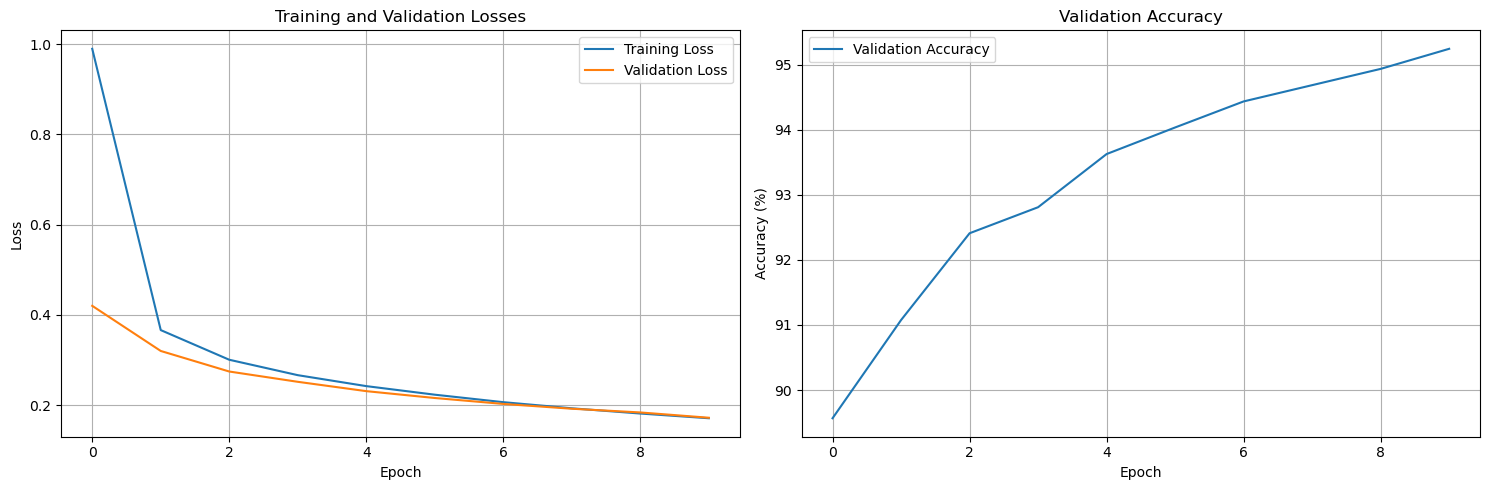

In [17]:
# Start training
trainer.fit()

# Plot the losses and accuracies
trainer.plot_losses()

### The GRU model 

Following the GRU formulation to build the model:

Reset gate: $\mathbf{R}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xr}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hr}}+\mathbf{b}_{\mathrm{r}}\right)$ (1)

Update gate: $\mathbf{Z}_t=\sigma\left(\mathbf{X}_t \mathbf{W}_{\mathrm{xz}}+\mathbf{H}_{t-1} \mathbf{W}_{\mathrm{hz}}+\mathbf{b}_{\mathrm{z}}\right)$ (2)

Candidate Hidden State: $\tilde{\mathbf{H}}_t=\tanh \left(\mathbf{X}_t \mathbf{W}_{\mathrm{xh}}+\left(\mathbf{R}_t \odot \mathbf{H}_{t-1}\right) \mathbf{W}_{\mathrm{hh}}+\mathbf{b}_{\mathrm{h}}\right)$ (3)

Hidden state: $\mathbf{H}_t=\mathbf{Z}_t \odot \mathbf{H}_{t-1}+\left(1-\mathbf{Z}_t\right) \odot \tilde{\mathbf{H}}_t$ (4)

In [18]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, lr):
        super(GRU, self).__init__()
        self.lr = lr
        self.hidden_dim = hidden_dim
        
        # Reset gate parameters
        self.W_xr = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hr = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_r = nn.Parameter(torch.zeros(hidden_dim))
        
        # Update gate parameters
        self.W_xz = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hz = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_z = nn.Parameter(torch.zeros(hidden_dim))
        
        # Candidate hidden state parameters
        self.W_xh = nn.Linear(input_dim, hidden_dim, bias=False)
        self.W_hh = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.b_h = nn.Parameter(torch.zeros(hidden_dim))
        
        # Final classification layer
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, inputs, H=None):
        batch_size = inputs.size(0)
        seq_length = inputs.size(1)  # Should be 1 in our case
        
        # Initialize hidden state if not provided
        if H is None:
            H = torch.zeros(batch_size, self.hidden_dim).to(inputs.device)
        
        # Process each timestep
        for t in range(seq_length):
            x_t = inputs[:, t, :]  # Get input for current timestep
            
            # Calculate gates
            R = torch.sigmoid(self.W_xr(x_t) + self.W_hr(H) + self.b_r)
            Z = torch.sigmoid(self.W_xz(x_t) + self.W_hz(H) + self.b_z)
            
            # Calculate candidate hidden state
            H_tilde = torch.tanh(self.W_xh(x_t) + self.W_hh(R * H) + self.b_h)
            
            # Update hidden state
            H = Z * H + (1 - Z) * H_tilde
        
        # Project to output classes
        logits = self.fc(H)
        
        return logits
        
    def loss(self, Y_hat, Y, averaged=True):
        loss = F.cross_entropy(Y_hat, Y, reduction='mean' if averaged else 'none')
        return loss
        
    def optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)



### Training the GRU model, and plotting

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.86MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 298kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 4.57MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 45.9kB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10]: Train Loss: 1.7179, Val Loss: 1.2557, Val Acc: 69.58%
Epoch [2/10]: Train Loss: 1.0377, Val Loss: 0.8788, Val Acc: 73.86%
Epoch [3/10]: Train Loss: 0.8007, Val Loss: 0.7382, Val Acc: 75.99%
Epoch [4/10]: Train Loss: 0.7007, Val Loss: 0.6682, Val Acc: 77.39%
Epoch [5/10]: Train Loss: 0.6445, Val Loss: 0.6243, Val Acc: 78.56%
Epoch [6/10]: Train Loss: 0.6064, Val Loss: 0.5918, Val Acc: 79.62%
Epoch [7/10]: Train Loss: 0.5776, Val Loss: 0.5672, Val Acc: 80.42%
Epoch [8/10]: Train Loss: 0.5548, Val Loss: 0.5478, Val Acc: 81.10%
Epoch [9/10]: Train Loss: 0.5365, Val Loss: 0.5318, Val Acc: 81.53%
Epoch [10/10]: Train Loss: 0.5210, Val Loss: 0.5184, Val Acc: 82.08%


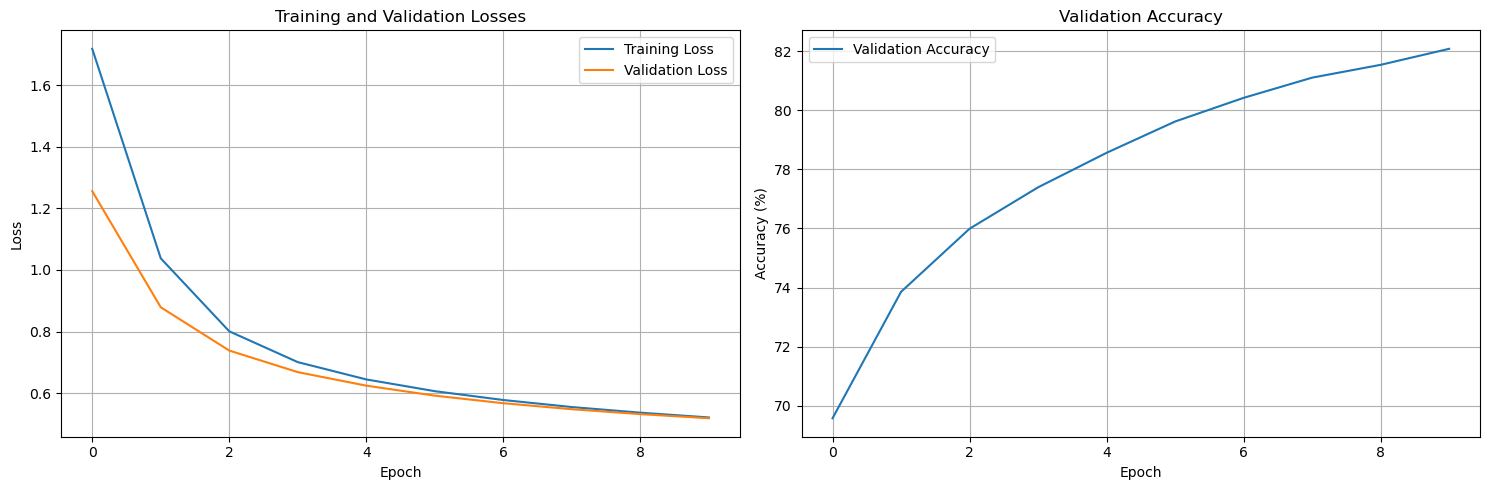

In [19]:
# Dataset implementation
class MNISTSequenceDataset(Dataset):
    def __init__(self, mnist_dataset):
        self.mnist_dataset = mnist_dataset
    
    def __len__(self):
        return len(self.mnist_dataset)
    
    def __getitem__(self, idx):
        image, label = self.mnist_dataset[idx]
        # Reshape (1, 28, 28) to (1, 784) - single timestep with full image
        sequence = image.view(1, 784)  # Shape: [1, 784]
        return sequence, label

# Training setup
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
sequence_dataset = MNISTSequenceDataset(mnist_dataset)

# Hyperparameters
batch_size = 256
model = GRU(
    input_dim=784,        # Flattened image size
    hidden_dim=128,       # Hidden state dimension
    num_classes=10,       # Number of classes
    lr=0.01              # Learning rate
)

# Create trainer
trainer = Trainer_cls(
    model=model,
    data=sequence_dataset,
    max_epochs=10,
    batch_size=batch_size,
    val_ratio=0.2
)

# Start training
trainer.fit()

# Plot results
trainer.plot_losses()

# Graph Convolutional Networks for node classification

### GCN model

Follow the GCN paper (https://arxiv.org/pdf/1609.02907) to construct a 2-layer GCN model.

First, given a symmetric adjacency matrix $A$, construct the adjacency matrix in spectural space $\hat{A}$:

$\hat{A}=\tilde{D}^{-\frac{1}{2}} \tilde{A} \tilde{D}^{-\frac{1}{2}},$ (1)

where $\tilde{A}=A+I_N$ (adjacency matrix with added self-connections) and $\tilde{D}_{i i}=\sum_j \tilde{A}_{i j}$.

With $\hat{A}$, construct the 2-layer GCN model:

$Z=f(X, A)=\operatorname{softmax}\left(\hat{A} \operatorname{ReLU}\left(\hat{A} X W^{(0)}\right) W^{(1)}\right).$ (2)

In [21]:
import torch_geometric
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.logging import init_wandb, log
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_dense_adj
import scipy.sparse as sparse
import numpy as np

In [35]:
def normalize_adjacency(adj):
    
    adj = adj + torch.eye(adj.size(0), device=adj.device)

    # construct $\tilde{D}^{-\frac{1}{2}}$

    degree_matrix = adj.sum(1)
    degree_inv_sqrt = torch.pow(degree_matrix, -0.5)
    degree_inv_sqrt[degree_inv_sqrt == float('inf')] = 0
    D_tilde_inv_sqrt = torch.diag(degree_inv_sqrt)

    # get A^hat using equation (1)
    adj = torch.mm(torch.mm(D_tilde_inv_sqrt, adj), D_tilde_inv_sqrt)
    return adj

### Constructing the GCN model 

 

In [23]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=True):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):
        x = torch.mm(x, self.weight)  # Project features first
        if self.bias is not None:
            x = x + self.bias
        # Message passing using normalized adjacency matrix
        return torch.sparse.mm(adj, x) if adj.is_sparse else torch.mm(adj, x)

class GCN(nn.Module):
    def __init__(self, node_features, hidden_dim, num_classes, dropout, lr, use_bias=True):
        super(GCN, self).__init__()
        self.lr = lr
        self.gcn_1 = GCNLayer(node_features, hidden_dim, use_bias)
        self.gcn_2 = GCNLayer(hidden_dim, num_classes, use_bias)
        self.dropout = nn.Dropout(dropout)

    def initialize_weights(self):
        self.gcn_1.initialize_weights()
        self.gcn_2.initialize_weights()

    def forward(self, x, adj):
        x = self.gcn_1(x, adj)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.gcn_2(x, adj)
        return F.log_softmax(x, dim=1)

    def loss(self, out, y, mask):
        return F.nll_loss(out[mask], y[mask])

    def optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=5e-3)

def normalize_adjacency(adj):
    # Add self-connections: A_tilde = A + I
    adj = adj + torch.eye(adj.size(0), device=adj.device)
    
    # Calculate degree matrix: D_tilde
    degree = adj.sum(1)
    degree_sqrt_inv = torch.pow(degree, -0.5)
    degree_sqrt_inv[degree_sqrt_inv == float('inf')] = 0
    
    # Calculate D^(-1/2) * A * D^(-1/2)
    degree_sqrt_inv = torch.diag(degree_sqrt_inv)
    return torch.mm(torch.mm(degree_sqrt_inv, adj), degree_sqrt_inv)



### Construct the graph node classification trainer 

In [24]:
class Trainer_cls_graph:
    def __init__(self, model, x, y, adj, data, max_epochs=200, device='cuda'):
        self.model = model
        self.max_epochs = max_epochs
        self.optimizer = model.optimizers()
        self.device = device
        self.adj = adj
        self.x = x
        self.y = y
        
        # Get masks from PyG data
        self.train_mask = data.train_mask
        self.val_mask = data.val_mask
        self.test_mask = data.test_mask
        
        # Metrics storage
        self.train_losses = []
        self.val_losses = []
        self.val_acc = []
        self.test_acc = []

    def fit(self):
        for epoch in range(self.max_epochs):
            # Training phase
            self.model.train()
            self.optimizer.zero_grad()
            
            output = self.model(self.x, self.adj)
            train_loss = self.model.loss(output, self.y, self.train_mask)
            
            train_loss.backward()
            self.optimizer.step()

            # Validation phase
            self.model.eval()
            with torch.no_grad():
                output = self.model(self.x, self.adj)
                val_loss = self.model.loss(output, self.y, self.val_mask)
                
                # Calculate accuracies
                pred = output.argmax(dim=1)
                val_correct = (pred[self.val_mask] == self.y[self.val_mask]).sum()
                val_accuracy = val_correct / self.val_mask.sum() * 100
                
                test_correct = (pred[self.test_mask] == self.y[self.test_mask]).sum()
                test_accuracy = test_correct / self.test_mask.sum() * 100

            # Store metrics
            self.train_losses.append(train_loss.item())
            self.val_losses.append(val_loss.item())
            self.val_acc.append(val_accuracy.item())
            self.test_acc.append(test_accuracy.item())
            
            print(f'Epoch [{epoch + 1}/{self.max_epochs}]: '
                  f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, '
                  f'Val Acc: {val_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

    def plot_losses(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Training Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training and Validation Losses')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.val_acc, label='Validation Accuracy')
        ax2.plot(self.test_acc, label='Test Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.set_title('Validation and Test Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()



### Training the GCN model and plot

Processing...
Done!


Epoch [1/200]: Train Loss: 1.9413, Val Loss: 1.9099, Val Acc: 30.80%, Test Acc: 30.50%
Epoch [2/200]: Train Loss: 1.8486, Val Loss: 1.8529, Val Acc: 43.60%, Test Acc: 44.70%
Epoch [3/200]: Train Loss: 1.7434, Val Loss: 1.7799, Val Acc: 55.20%, Test Acc: 58.50%
Epoch [4/200]: Train Loss: 1.5983, Val Loss: 1.7069, Val Acc: 58.80%, Test Acc: 61.10%
Epoch [5/200]: Train Loss: 1.4851, Val Loss: 1.6365, Val Acc: 61.60%, Test Acc: 63.80%
Epoch [6/200]: Train Loss: 1.3571, Val Loss: 1.5665, Val Acc: 65.20%, Test Acc: 66.30%
Epoch [7/200]: Train Loss: 1.2266, Val Loss: 1.4950, Val Acc: 67.60%, Test Acc: 69.50%
Epoch [8/200]: Train Loss: 1.1364, Val Loss: 1.4253, Val Acc: 70.00%, Test Acc: 71.40%
Epoch [9/200]: Train Loss: 1.0097, Val Loss: 1.3591, Val Acc: 71.20%, Test Acc: 72.30%
Epoch [10/200]: Train Loss: 0.8903, Val Loss: 1.2972, Val Acc: 72.40%, Test Acc: 73.80%
Epoch [11/200]: Train Loss: 0.8255, Val Loss: 1.2388, Val Acc: 74.40%, Test Acc: 74.70%
Epoch [12/200]: Train Loss: 0.7685, Val L

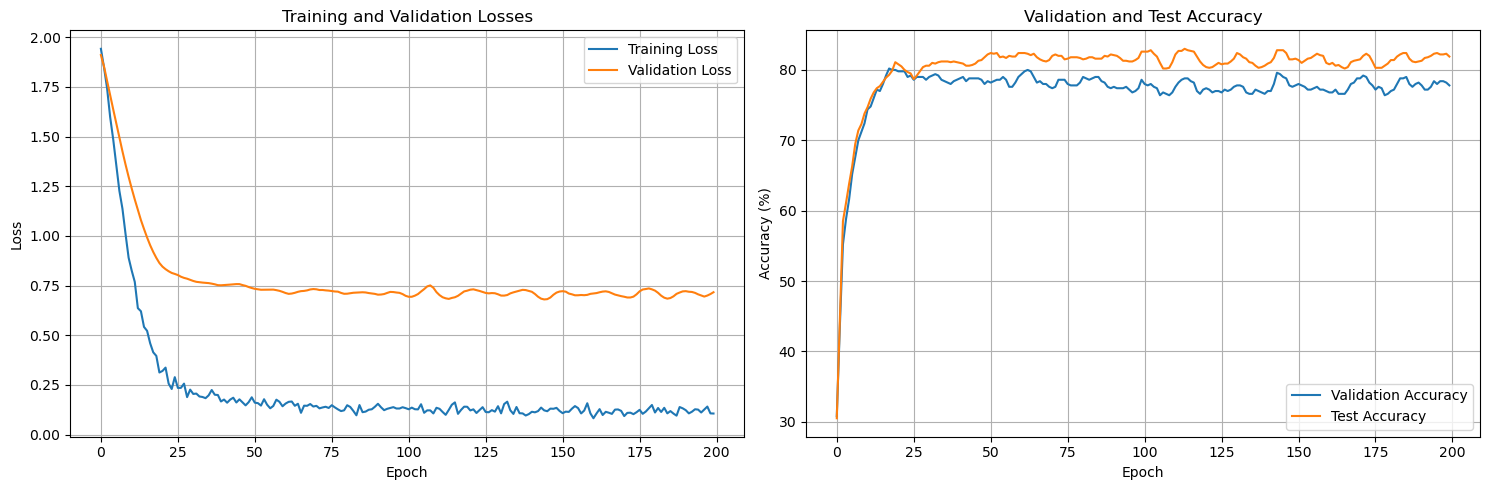

In [25]:
# Training setup
dataset = Planetoid(root='data/Cora', name='Cora')
data = dataset[0].to('cuda')
adj = to_dense_adj(data.edge_index)[0].to('cuda')
adj = normalize_adjacency(adj)

# Model instantiation
model = GCN(
    node_features=dataset.num_features,
    hidden_dim=16,  # As per paper
    num_classes=dataset.num_classes,
    dropout=0.5,
    lr=0.01
).to('cuda')

# Create trainer
trainer = Trainer_cls_graph(
    model=model,
    x=data.x,
    y=data.y,
    adj=adj,
    data=data,
    max_epochs=200
)

# Train and plot
trainer.fit()
trainer.plot_losses()

### Understanding heterophily(disimilar nodes tend to connect) in graph and compare the performance with different heterophily 

Cora Dataset:
Labels shape: torch.Size([2708])
Train mask shape: torch.Size([2708])
Val mask shape: torch.Size([2708])
Test mask shape: torch.Size([2708])

Texas Dataset:
Labels shape: torch.Size([183])
Train mask shape: torch.Size([183])
Val mask shape: torch.Size([183])
Test mask shape: torch.Size([183])

Homophily of Cora: 0.8100
Heterophily of Cora: 0.1900

Homophily of Texas: 0.1077
Heterophily of Texas: 0.8923



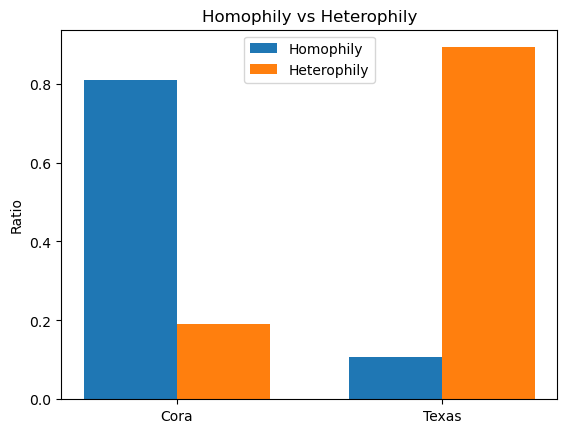

Training on Cora (Homophilic)...
Epoch: 001, Loss: 1.9410, Train Acc: 0.4929, Val Acc: 0.3400, Test Acc: 0.3410
Epoch: 010, Loss: 0.8669, Train Acc: 0.9500, Val Acc: 0.6940, Test Acc: 0.7110
Epoch: 020, Loss: 0.2777, Train Acc: 1.0000, Val Acc: 0.7520, Test Acc: 0.7920
Epoch: 030, Loss: 0.1487, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.8010
Epoch: 040, Loss: 0.0665, Train Acc: 1.0000, Val Acc: 0.7780, Test Acc: 0.7980
Epoch: 050, Loss: 0.0568, Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.7920
Epoch: 060, Loss: 0.0613, Train Acc: 1.0000, Val Acc: 0.7780, Test Acc: 0.7950
Epoch: 070, Loss: 0.0494, Train Acc: 1.0000, Val Acc: 0.7720, Test Acc: 0.7880
Epoch: 080, Loss: 0.0470, Train Acc: 1.0000, Val Acc: 0.7620, Test Acc: 0.7790
Epoch: 090, Loss: 0.0366, Train Acc: 1.0000, Val Acc: 0.7660, Test Acc: 0.7930
Epoch: 100, Loss: 0.0431, Train Acc: 1.0000, Val Acc: 0.7680, Test Acc: 0.7880
Epoch: 110, Loss: 0.0455, Train Acc: 1.0000, Val Acc: 0.7740, Test Acc: 0.7950
Epoch: 120, Loss: 0

In [42]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, WebKB
from torch_geometric.nn import GCNConv
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_datasets():
    """
    Load the Cora and a selected heterophilic WebKB dataset (e.g., Texas).
    For the Texas dataset, create 1D validation and test masks if they don't exist.
    """
    # Load Cora dataset (homophilic)
    cora = Planetoid(root='/tmp/Cora', name='Cora')[0]

    # Load Texas dataset (heterophilic) from WebKB
    texas = WebKB(root='/tmp/WebKB', name='Texas')[0]

    # Create masks for Texas if they don't exist or are incorrectly shaped
    num_nodes = texas.num_nodes

    # Overwrite any existing masks to ensure they are 1D
    # Calculate sizes for train, val, and test sets
    val_size = max(int(0.2 * num_nodes), 1)  # 20% for validation
    test_size = max(int(0.1 * num_nodes), 1)  # 10% for testing
    train_size = num_nodes - val_size - test_size  # Remaining for training

    # Generate a random permutation of node indices
    perm = torch.randperm(num_nodes)

    # Assign indices to each split
    train_indices = perm[:train_size]
    val_indices = perm[train_size:train_size + val_size]
    test_indices = perm[train_size + val_size:]

    # Initialize masks as 1D boolean tensors
    texas.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    texas.train_mask[train_indices] = True

    texas.val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    texas.val_mask[val_indices] = True

    texas.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    texas.test_mask[test_indices] = True

    return cora, texas

def compute_homophily(data):
    """
    Compute the homophily ratio of a graph.
    Homophily is defined as the fraction of edges that connect nodes of the same class.
    """
    edge_index = data.edge_index
    labels = data.y

    # Ensure labels are 1D
    if labels.dim() > 1:
        labels = labels.argmax(dim=1)

    # Number of edges where both nodes have the same label
    same_class = labels[edge_index[0]] == labels[edge_index[1]]
    homophily = int(same_class.sum()) / edge_index.size(1)

    return homophily

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        # First GCN layer with ReLU activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Dropout for regularization
        x = F.dropout(x, p=0.5, training=self.training)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    
    # Ensure train_mask is 1D
    if data.train_mask.dim() > 1:
        raise ValueError(f"train_mask has incorrect shape: {data.train_mask.shape}. Expected 1D tensor.")
    
    # Ensure labels are 1D
    if data.y.dim() > 1:
        # Convert one-hot to class indices
        data.y = data.y.argmax(dim=1)
    
    # Only compute loss on training nodes
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accuracies = {}
    for split in ['train_mask', 'val_mask', 'test_mask']:
        if hasattr(data, split):
            mask = getattr(data, split)
            if mask.dim() > 1:
                raise ValueError(f"{split} has incorrect shape: {mask.shape}. Expected 1D tensor.")
            if mask.sum().item() == 0:
                accuracies[split] = 0
                continue
            correct = pred[mask] == data.y[mask]
            acc = int(correct.sum()) / int(mask.sum())
            accuracies[split] = acc
    return accuracies

def run_experiment(data, dataset_name, hidden_channels=16, lr=0.01, weight_decay=5e-4, epochs=200):
    """
    Train and evaluate a GCN model on the given dataset.
    """
    # Dynamically determine number of features and classes
    num_features = data.num_features if hasattr(data, 'num_features') else data.x.size(1)
    
    # Ensure labels are 1D
    if data.y.dim() > 1:
        data.y = data.y.argmax(dim=1)
    
    num_classes = data.num_classes if hasattr(data, 'num_classes') else data.y.max().item() + 1

    model = GCN(num_features=num_features,
                hidden_channels=hidden_channels,
                num_classes=num_classes).to(device)
    data = data.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    best_val_acc = 0
    test_acc_at_best_val = 0

    for epoch in range(1, epochs + 1):
        try:
            loss = train(model, data, optimizer, criterion)
        except ValueError as ve:
            print(f"ValueError during training: {ve}")
            break
        accs = test(model, data)
        val_acc = accs.get('val_mask', 0)
        test_acc = accs.get('test_mask', 0)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc_at_best_val = test_acc
        if epoch % 10 == 0 or epoch == 1:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, '
                  f'Train Acc: {accs.get("train_mask", 0):.4f}, '
                  f'Val Acc: {accs.get("val_mask", 0):.4f}, '
                  f'Test Acc: {accs.get("test_mask", 0):.4f}')

    print(f'Best Val Acc: {best_val_acc:.4f}, Test Acc at Best Val: {test_acc_at_best_val:.4f}\n')
    return test_acc_at_best_val

def main():
    # Load datasets
    cora, texas = load_datasets()

    # Diagnostic: Print shapes of labels and masks
    print("Cora Dataset:")
    print(f"Labels shape: {cora.y.shape}")
    print(f"Train mask shape: {cora.train_mask.shape}")
    print(f"Val mask shape: {cora.val_mask.shape}")
    print(f"Test mask shape: {cora.test_mask.shape}\n")

    print("Texas Dataset:")
    print(f"Labels shape: {texas.y.shape}")
    print(f"Train mask shape: {texas.train_mask.shape}")
    print(f"Val mask shape: {texas.val_mask.shape}")
    print(f"Test mask shape: {texas.test_mask.shape}\n")

    # Compute homophily
    cora_homophily = compute_homophily(cora)
    texas_homophily = compute_homophily(texas)

    print(f'Homophily of Cora: {cora_homophily:.4f}')
    print(f'Heterophily of Cora: {1 - cora_homophily:.4f}\n')

    print(f'Homophily of Texas: {texas_homophily:.4f}')
    print(f'Heterophily of Texas: {1 - texas_homophily:.4f}\n')

    # Plot homophily comparison
    labels = ['Cora', 'Texas']
    homophily = [cora_homophily, texas_homophily]
    heterophily = [1 - cora_homophily, 1 - texas_homophily]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, homophily, width, label='Homophily')
    rects2 = ax.bar(x + width/2, heterophily, width, label='Heterophily')

    ax.set_ylabel('Ratio')
    ax.set_title('Homophily vs Heterophily')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

    # Run experiments
    print('Training on Cora (Homophilic)...')
    cora_test_acc = run_experiment(cora, 'Cora')

    print('Training on Texas (Heterophilic)...')
    texas_test_acc = run_experiment(texas, 'Texas')

    # Compare results
    print('Comparison of Test Accuracies:')
    print(f'Cora (Homophilic): {cora_test_acc:.4f}')
    print(f'Texas (Heterophilic): {texas_test_acc:.4f}')

    
if __name__ == '__main__':
    main()


The stark performance difference between Cora (80.50% accuracy) and Texas (27.78% accuracy) datasets demonstrates how heterophily impacts GCN performance. This occurs because GCNs assume connected nodes share similar features and labels - true for Cora's homophilic nature (0.81) but false for Texas's heterophilic structure (0.89), where connected nodes typically belong to different classes, leading to conflicting information during feature aggregation.